# This is the deep learning project, on the Image super resolution.

## This project consist of three parts, 
 
 - Data preprocessing part, which consist of patching the datasets and applying data augmentation.
 - Training of the model 
 - Evaluatioon of the model.



In [1]:

from google.colab import drive
drive.mount('/content/drive')





Mounted at /content/drive


In [2]:
# pip install lpips for model evaluation
pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.1 MB/s eta 0:00:00


Pre processing ->
Patching ->
Model ->
training  ->
testing


# **Importing the neccessary Libaries**

Here, we import the neccessary libaries that will be used all through out the project

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
from skimage.color import rgb2ycbcr, ycbcr2rgb
import matplotlib.pyplot as plt
import random
from torchsummary import summary
from skimage.color import rgb2ycbcr, ycbcr2rgb
from mpl_toolkits.axes_grid1 import ImageGrid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available

device

device(type='cuda')

In [4]:
SEED = 31
np.random.seed(SEED)

# **Preprocessing the file path**

Since the folder containing the images was subdivided into low and high resolution, in order to have access to each of the 
images path, we performs some text processing to have all the images path in a list.

The len of the training data is:  800
The len of the validation data is:  100



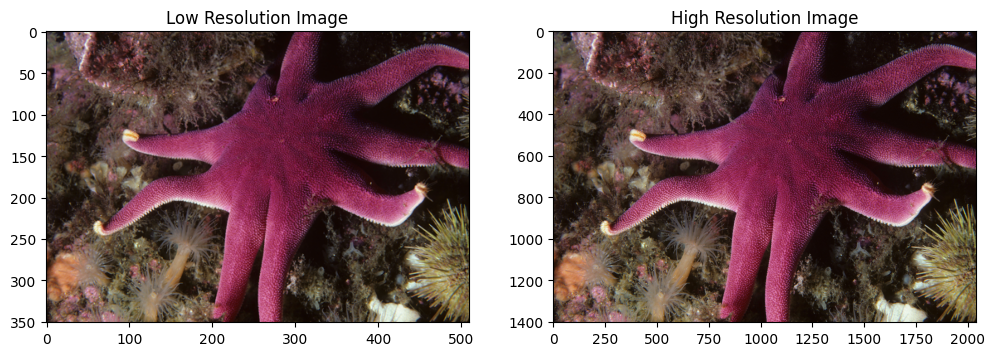

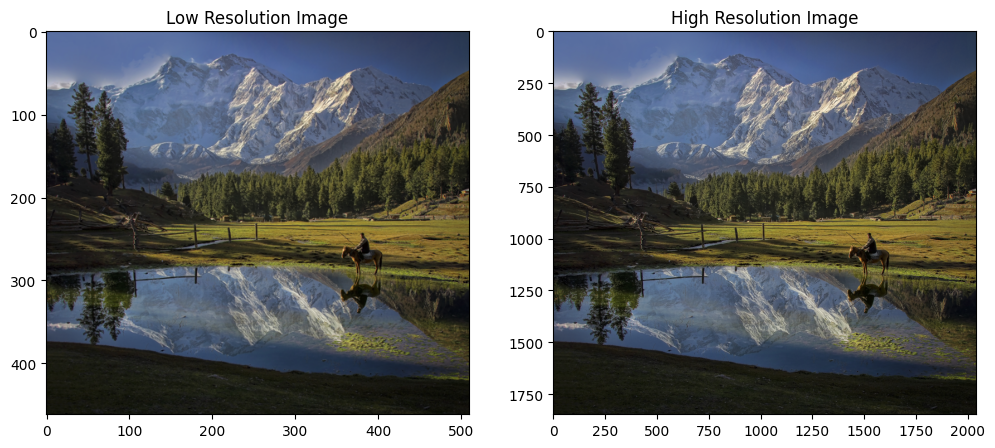

In [4]:
folder_path="/content/drive/MyDrive/Deep learning Project"

list_of_data_path=sorted(os.listdir(folder_path))[1:] # This sorts the folder name and slice it to remove the .ipynb_checkpoints folder

high_resolution_training_dir=os.path.join(folder_path,list_of_data_path[0]+'/'+'DIV2K_train_HR') # contains the directory of the high resolution images folder for training
low_resolution_training_dir=os.path.join(folder_path,list_of_data_path[1]+'/'+'DIV2K_train_LR_bicubic'+'/X4') # contains the directory of the low resolution images folder for training
high_resolution_validation_dir=os.path.join(folder_path,list_of_data_path[2]+'/'+'DIV2K_valid_HR') # contains the directory of the high resolution images folder for validation
low_resolution_validation_dir=os.path.join(folder_path,list_of_data_path[3]+'/'+'DIV2K_valid_LR_bicubic'+'/X4') # contains the directory of the low resolution images folder for validation

# Since the folder containe different folders, the code below, extracting the different image path, from the different folders.
# That is, goes into different images folder (low training, low validation and corresponding high training and validation), extracts the image file
# and concatenates them with the correspinging folder path in order to have the image path.

high_resolution_training_paths=sorted(list(map(lambda x:os.path.join(high_resolution_training_dir,x),os.listdir(high_resolution_training_dir))))
low_resolution_training_paths=sorted(list(map(lambda x:os.path.join(low_resolution_training_dir,x),os.listdir(low_resolution_training_dir))))
high_resolution_validation_paths=sorted(list(map(lambda x:os.path.join(high_resolution_validation_dir,x),os.listdir(high_resolution_validation_dir))))
low_resolution_validation_paths=sorted(list(map(lambda x:os.path.join(low_resolution_validation_dir,x),os.listdir(low_resolution_validation_dir))))


# Prints the number of the training and validation images
print(f'The len of the training data is:  {len(high_resolution_training_paths)}')
print(f'The len of the validation data is:  {len(high_resolution_validation_paths)}')

print()


# plotting the sample of the low and high resolution images.
for low_image,high_image in zip(low_resolution_training_paths[:2],high_resolution_training_paths[:2]):
  low_image=plt.imread(low_image)
  high_image=plt.imread(high_image)
  plt.figure(figsize=(12,8))
  plt.subplot(1,2,1)
  plt.title("Low Resolution Image")
  plt.imshow(low_image)
  plt.subplot(1,2,2)
  plt.title("High Resolution Image")
  plt.imshow(high_image)
  plt.show()

# **Patching of the Dataset**

Here, we define a patching class which inherit the Dataset class from pytorch. This
 helps us patch the data set in to get the appropriate number of patches size. Ths enable the dataset to be loaded the datasets
 in batches as such managing efficiently the memory. This correspond to the low resolution patches with its corresponding high resolution patches

In [5]:

class PatchDataset(Dataset):
  '''
  Dataset patching implemetation. This class was gotten from https://colab.research.google.com/github/dzlab/notebooks/blob/master/_notebooks/2021-05-10-Super_Resolution_SRCNN.ipynb and adapted for our purpose


  Our own contribution to this class was:
      * Add the data augmentation techniques.
      * Convertion of the RGB patches to the YCrCB patches to extracts the y channel for training the model

  The class basically, takes and image and extracts the number of patches desired.
   '''
  def __init__(self, images_files_low, images_files_high, patch_size=40, number_of_patches=1):
    self.images_files_low = images_files_low
    self.images_files_high = images_files_high
    self.patch_size = patch_size
    self.number_of_patches = number_of_patches
    # define the transformation for data augmentation
    self.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=90)
        ])

  def __len__(self):
    return len(self.images_files_low) * self.number_of_patches

  def __getitem__(self, idx):
    img_idx = idx // self.number_of_patches
    low_file = self.images_files_low[img_idx]
    high_file = self.images_files_high[img_idx]

    # converts the file into a PIL image and the converts it back into a numpy array then scales it.

    low_image = np.array(Image.open(low_file)).astype('float32') / 255.0
    high_image = np.array(Image.open(high_file)).astype('float32') / 255.0

    # Apply the same random transformations to both low and high resolution images https://discuss.pytorch.org/t/dataloaders-multiprocess-with-torch-manual-seed/123044/5
    seed = torch.randint(0, 2**32, (1,)).item()
    torch.manual_seed(seed)
    low_tensor = self.transform(low_image)
    torch.manual_seed(seed)
    high_tensor = self.transform(high_image)


   # Generating random integer for x and y between 0 and W - self.patch_size to ensure that the limit is not reached. https://github.com/tweedlemoon/RetinexNet/blob/master/model.py (def train function)
    _, H, W = low_tensor.shape
    x = torch.randint(0, W - self.patch_size, (1,)).item()
    y = torch.randint(0, H - self.patch_size, (1,)).item()

    # extracts the low rgb patches   https://github.com/tweedlemoon/RetinexNet/blob/master/model.py (def train function)
    low_patch_rgb = low_tensor[:, y:y+self.patch_size, x:x+self.patch_size]
    # converts the low rgb pathcs into a ycbcr
    low_patch_ycbcr = rgb2ycbcr(low_patch_rgb.permute(1, 2, 0).cpu().numpy())
    #extracts the y channel from the low ycbcr
    low_patch_y = torch.from_numpy(low_patch_ycbcr[:,:,0]).unsqueeze(0)


    # Gets the corresponding high patches
    high_x, high_y = x*4, y*4
    high_patch_size = self.patch_size * 4
    high_patch_rgb = high_tensor[:, high_y:high_y+high_patch_size, high_x:high_x+high_patch_size]
    # converts the high rgb pathcs into a ycbcr
    high_patch_ycbcr = rgb2ycbcr(high_patch_rgb.permute(1, 2, 0).cpu().numpy())
    #extracts the y channel from the high ycbcr. This wil be useful for the loss calculation
    high_patch_y = torch.from_numpy(high_patch_ycbcr[:,:,0]).unsqueeze(0)

    return low_patch_rgb, high_patch_rgb, low_patch_y, high_patch_y




# Defining the training dataset with patch
train_dataset=PatchDataset(low_resolution_training_paths,high_resolution_training_paths,patch_size=40,number_of_patches=40)

train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True, num_workers=2)


# **Visualisation of the patches for training**

This is the low patch images


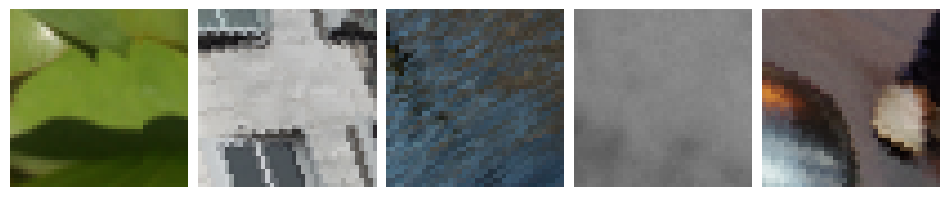


This the high patch images


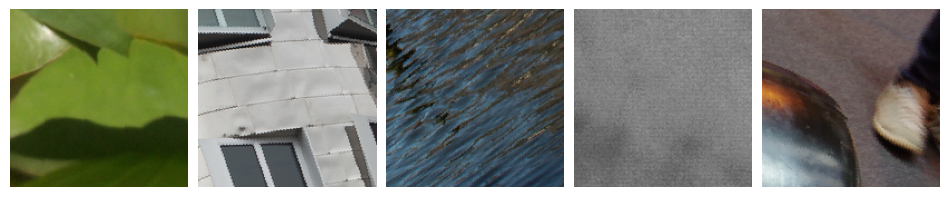


This the low patch images in Y channel


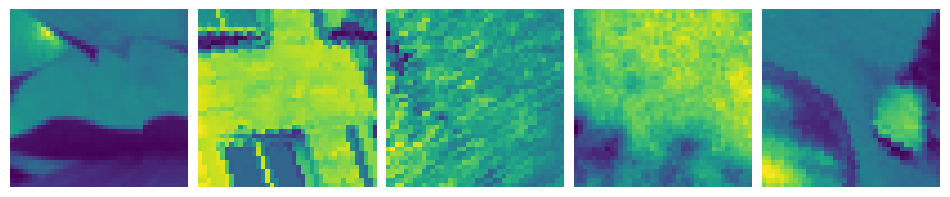


This the high patch images in Y channel


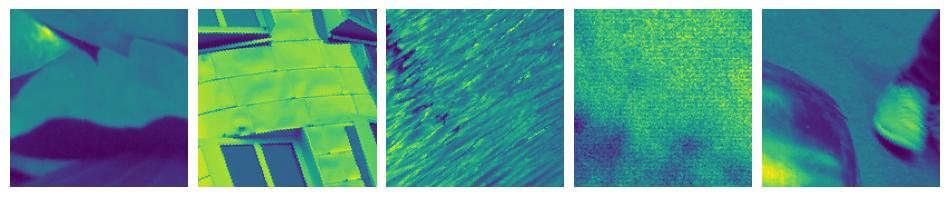

In [ ]:
def plot_patches(tensor):

  '''
  This is function that helps in visualising the patches.
  This has been taken from https://mrinath.medium.com/vit-part-1-patchify-images-using-pytorch-unfold-716cd4fd4ef6
  '''
  fig = plt.figure(figsize=(12, 12))
  grid = ImageGrid(fig, 111, nrows_ncols=(1,5), axes_pad=0.1)

  for i, ax in enumerate(grid):
    patch = tensor[i].permute(1, 2, 0).numpy()
    ax.imshow(patch)
    ax.axis('off')

  plt.show()


for batch_id, (low_patches_rgb, high_patches_rgb,low_patches_y,high_patches_y) in enumerate(train_dataloader):
    # Process your batches here

    print("This is the low patch images")
    plot_patches(low_patches_rgb)

    print()

    print('This the high patch images')
    plot_patches(high_patches_rgb)

    print()

    print('This the low patch images in Y channel')
    plot_patches(low_patches_y)

    print()

    print('This the high patch images in Y channel')
    plot_patches(high_patches_y)

    if batch_id==0:
      break


# **Model Architecture**

Here we define our model architecture which is the VDSR

In [6]:


import torch
import torch.nn as nn
from torchsummary import summary

class VDSR(nn.Module):


  '''
  VDSR model implimentation. This is based on the paper

  Kim, Jiwon et al. “Accurate Image Super-Resolution Using Very Deep Convolutional Networks.”
  2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR) (2015):1646-1654.

  Code taken and adapted from https://github.com/Lornatang/VDSR-PyTorch
  '''
  def __init__(self, num_channels=1):
    super(VDSR, self).__init__()
    self.layers = nn.ModuleList()
    self.first_layer = nn.Conv2d(num_channels, 64, kernel_size=3, padding=1)
    self.last_layer = nn.Conv2d(64, num_channels, kernel_size=3, padding=1)

    self.residual_layers = nn.ModuleList([nn.Conv2d(64, 64, kernel_size=3, padding=1) for _ in range(18)])

    self.layers.append(self.first_layer)
    self.layers.extend(self.residual_layers)
    self.layers.append(self.last_layer)
    self.relu = nn.ReLU()

  def forward(self, x):
    residual = x
    x = self.relu(self.first_layer(x))

    for layer in self.residual_layers:
      x = self.relu(layer(x))

    x = self.last_layer(x)
    return x + residual





For Continues training, we had to load the check points

In [ ]:
# Loading the model after saving the weights for training.
model=VDSR().to(device)

# Loading the optimizer
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_function=nn.MSELoss()

checkpoint = torch.load('/content/drive/MyDrive/Deep learning Project/checkpoint2.pth', weights_only=False)
model.load_state_dict(checkpoint['model'])
optimizer_state=checkpoint['optimizer']

optimizer_state['param_groups'][0]['params'] = optimizer.param_groups[0]['params']
optimizer.load_state_dict(optimizer_state)

start_epoch = checkpoint['epoch']

train_loss_history = checkpoint['train_loss']
test_loss_history = checkpoint['test_loss']
pnsr_history = checkpoint['psnr']
ssim_history = checkpoint['ssim']
lpips_history = checkpoint['lpips']


epochs=40

# **Training and Evaluation**

At this point, we define two function, One for training, and one for validation. This training function has been taken from the 
lab sections and adapted to our needs.

In [7]:

print_every = 200

def train(epoch):
  '''
  Training function.

  @ params epoch
  @ return epoch_loss
  '''
  model.train()
  train_loss = 0
  total = 0

  for batch_idx, (inputs, targets,inputs_y,targets_y) in enumerate(train_dataloader):
    inputs_y, targets_y = inputs_y.to(device), targets_y.to(device)

    inputs_y = inputs_y
    targets_y = targets_y

    optimizer.zero_grad()
    upsampling =nn.Upsample(scale_factor=4, mode='bicubic')

    inputs=upsampling(inputs_y)
    inputs=inputs.to(device)

    outputs = model(inputs)
    outputs = outputs.squeeze(0)

    # calculation of the loss function
    loss = loss_function(outputs, targets_y)
    loss.backward()

    # Implement gradient clipping here
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    train_loss += loss.item()






    epoch_loss = train_loss/(batch_idx+1)


    if batch_idx % print_every == 0:
      print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}'.format(epoch, epochs, batch_idx, len(train_dataloader),
                                                                                   epoch_loss))

    return epoch_loss

lpips_loss = lpips.LPIPS(net='alex').to(device)

import torch
import numpy as np
from torchvision import transforms
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio

def test():
  '''
  Testing function.

  @ return epoch_loss, epoch_psnr, epoch_ssim, epoch_lpips
  '''
  model.eval()
  test_loss = 0
  lpips_total = 0
  psnr_total = 0
  ssim_total = 0

  # Define transform
  transform_to_tensor = transforms.ToTensor()

  with torch.no_grad():
    for i, (input_path, target_path) in enumerate(zip(low_resolution_validation_paths, high_resolution_validation_paths)):
      # Load images directly as PIL Images
      low_image = Image.open(input_path).convert('RGB')
      high_image =Image.open(target_path).convert('RGB')


      # Transform images to tensors
      low_tensor = transform_to_tensor(low_image).to(device)
      high_tensor = transform_to_tensor(high_image).to(device)

      # Convert high tensor to YCbCr and extract Y channel
      high_image_ycbcr = rgb2ycbcr(high_tensor.permute(1, 2, 0).cpu().numpy())
      low_image_ycbcr = rgb2ycbcr(low_tensor.permute(1, 2, 0).cpu().numpy())

      # Extract channels from YCbCr
      low_y = torch.from_numpy(low_image_ycbcr[:, :, 0]).unsqueeze(0).to(device)
      low_cb = torch.from_numpy(low_image_ycbcr[:, :, 1]).unsqueeze(0).to(device)
      low_cr = torch.from_numpy(low_image_ycbcr[:, :, 2]).unsqueeze(0).to(device)

      high_y = torch.from_numpy(high_image_ycbcr[:, :, 0]).unsqueeze(0).to(device)
      high_cb = torch.from_numpy(high_image_ycbcr[:, :, 1]).unsqueeze(0).to(device)
      high_cr = torch.from_numpy(high_image_ycbcr[:, :, 2]).unsqueeze(0).to(device)

      # Upsampling the y channel
      upsampling = nn.Upsample(scale_factor=4, mode='bicubic')
      inputs = upsampling(low_y.unsqueeze(0)).squeeze(0)  # Shape: [C, H', W']
      low_upsampled_cb = upsampling(low_cb.unsqueeze(0)).squeeze(0)
      low_upsampled_cr = upsampling(low_cr.unsqueeze(0)).squeeze(0)

      # Model prediction
      output = model(inputs)


      # Calucaltion of the loss function
      loss = loss_function(output, high_y)



      # Convert output back to RGB from YCbCr
      low_image_rgb = ycbcr2rgb(np.stack([output.squeeze().cpu().numpy(), low_upsampled_cb.squeeze().cpu().numpy(), low_upsampled_cr.squeeze().cpu().numpy()], axis=-1))

      # Convert back into tensors for metrics calculation
      output_tensor = transform_to_tensor(low_image_rgb).to(device)


      # Calculate metrics (LPIPS, PSNR, SSIM)
      lpips = lpips_loss(output_tensor, high_tensor.unsqueeze(0)).mean()  # Ensure shapes match for LPIPS calculation

      psnr_value = peak_signal_noise_ratio(output_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                                  high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1.0)

      ssim_value = structural_similarity(output_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                               high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                               win_size=3, data_range=1.0)

      test_loss += loss.item()
      lpips_total += lpips.item()
      psnr_total += psnr_value
      ssim_total += ssim_value

      # Calculating the average test loss, lpips, psnr and ssim

    epoch_loss = test_loss / (i + 1)
    epoch_lpips = lpips_total / (i + 1)
    epoch_psnr = psnr_total / (i + 1)
    epoch_ssim = ssim_total / (i + 1)

    print('Test Loss: {:.3f}, PSNR: {:.3f}, SSIM: {:.3f}, LPIPS: {:.3f}'.format(
                epoch_loss, epoch_psnr, epoch_ssim, epoch_lpips))

  return epoch_loss, epoch_psnr, epoch_ssim, epoch_lpips







Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 228MB/s]
/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle mod

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


# **Evaluation for the Bicubic Images**

Here, we perform an evaluation of the upsampled images on the validation data based on the bicubic interpolation.

In [72]:

def bicubic_evaluation():
    # Define transform
  transform_to_tensor = transforms.ToTensor()

  psrn_bicubic=[]
  ssims_bicubic=[]
  lpips_bicubic=[]

  for i, (input_path, target_path) in enumerate(zip(low_resolution_validation_paths, high_resolution_validation_paths)):

    # Load images directly as PIL Images
    low_image = Image.open(input_path).convert('RGB')
    high_image =Image.open(target_path).convert('RGB')


    # Transform images to tensors
    low_tensor = transform_to_tensor(low_image).to(device)
    high_tensor = transform_to_tensor(high_image).to(device)

    upsampling = nn.Upsample(scale_factor=4, mode='bicubic')
    low_tensor=upsampling(low_tensor.unsqueeze(0)).squeeze(0)
    low_tensor=low_tensor.to(device)








    # Calculate metrics (LPIPS, PSNR, SSIM)
    lpips = lpips_loss(low_tensor.unsqueeze(0), high_tensor.unsqueeze(0)).mean()  # Ensure shapes match for LPIPS calculation

    psnr_value = peak_signal_noise_ratio(low_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                                  high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1.0)

    ssim_value = structural_similarity(low_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                               high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                               win_size=3, data_range=1.0)

    psrn_bicubic.append(psnr_value)
    ssims_bicubic.append(ssim_value)
    lpips_bicubic.append(lpips.item())

  return psrn_bicubic,ssims_bicubic,lpips_bicubic

psrn_bicubic,ssims_bicubic,lpips_bicubic=bicubic_evaluation()

print(f"Average PSNR for bicubic images: {np.mean(psrn_bicubic)}")
print(f"Average SSIM for bicubic images: {np.mean(ssims_bicubic)}")
print(f"Average LPIPS for bicubic images: {np.mean(lpips_bicubic)}")



Average PSNR for bicubic images: 26.887223295396222
Average SSIM for bicubic images: 0.9117526159094954
Average LPIPS for bicubic images: 0.3014352560043335


# **Training and Evaluation** 

This cells calls the training and test function, above for each epochs. 

In [ ]:

best_psnr = 0

for epoch in range(start_epoch,epochs):
    epoch_loss = train(epoch)

    train_loss_history.append(epoch_loss)

    # appending all the metrcis scores in the list for plotting
    test_loss,psnr,ssim,lpip = test()
    test_loss_history.append(test_loss)
    pnsr_history.append(psnr)
    ssim_history.append(ssim)
    lpips_history.append(lpip)

# Saving the states of the model
    state = {'model': model.state_dict(),
             'epoch':epoch+1,
             'optimizer':optimizer.state_dict(),
             'train_loss':train_loss_history,
             'test_loss':test_loss_history,
             'psnr':pnsr_history,
             'ssim':ssim_history,
             'lpips':lpips_history}

    torch.save(state,'/content/drive/MyDrive/Deep learning Project/checkpoint2.pth')

    # saving the model only with the best PSNR
    if psnr>best_psnr:
        torch.save(model.state_dict(),'/content/drive/MyDrive/Deep learning Project/srfinal2.pth')
        best_psnr=psnr



Epoch 30/40, Iter 0/500, Train Loss: 159.672
Test Loss: 146.494, PSNR: 26.850, SSIM: 0.859, LPIPS: 0.288
Epoch 31/40, Iter 0/500, Train Loss: 183.482
Test Loss: 141.244, PSNR: 27.068, SSIM: 0.861, LPIPS: 0.310
Epoch 32/40, Iter 0/500, Train Loss: 169.719
Test Loss: 140.463, PSNR: 27.106, SSIM: 0.862, LPIPS: 0.318
Epoch 33/40, Iter 0/500, Train Loss: 143.570
Test Loss: 140.295, PSNR: 27.110, SSIM: 0.862, LPIPS: 0.317
Epoch 34/40, Iter 0/500, Train Loss: 147.040
Test Loss: 140.045, PSNR: 27.117, SSIM: 0.862, LPIPS: 0.311
Epoch 35/40, Iter 0/500, Train Loss: 189.755
Test Loss: 139.307, PSNR: 27.146, SSIM: 0.862, LPIPS: 0.306


KeyboardInterrupt: 

# **Visualisation of the metrcis**

At this phase, we visualize the evolution of the metrics with respect to the epochs

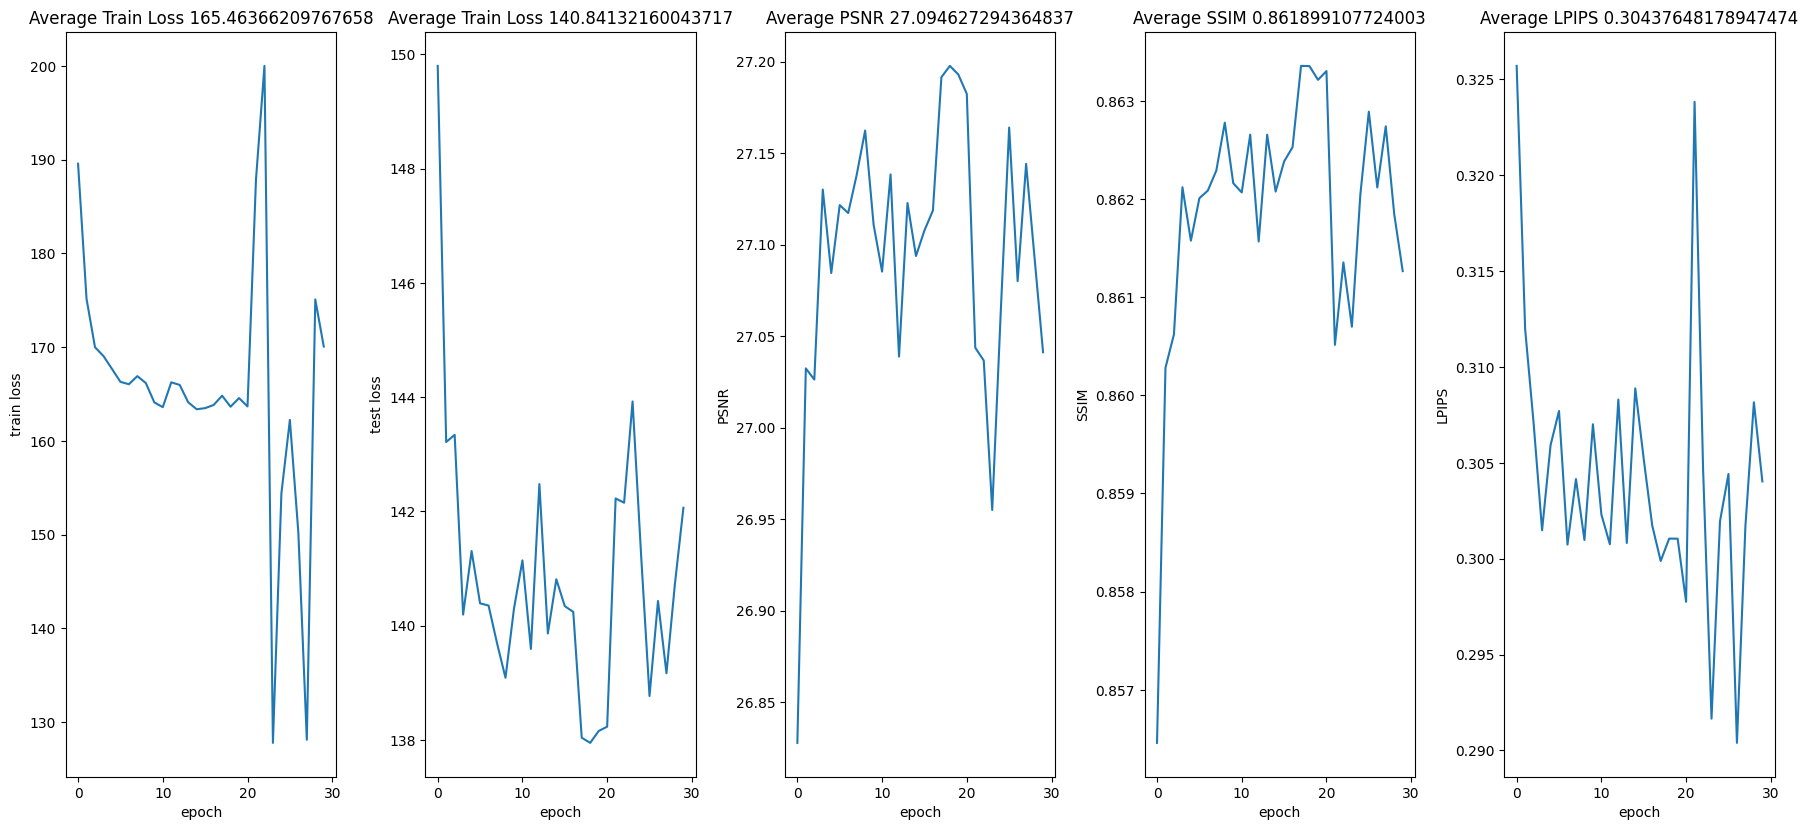

In [ ]:

plt.figure(figsize=(18,16))

# plotting the training loss
plt.subplot(2,5,1)
plt.title(f"Average Train Loss {np.mean(train_loss_history)}")
plt.plot(train_loss_history)
plt.xlabel('epoch')
plt.ylabel('train loss')

#plottinh the validation loss

plt.subplot(2,5,2)
plt.title(f"Average Test Loss {np.mean(test_loss_history)}")
plt.plot(test_loss_history)
plt.xlabel('epoch')
plt.ylabel('test loss')

# ploting the PSNR
plt.subplot(2,5,3)
plt.title(f"Average PSNR {np.mean(pnsr_history)}")

plt.plot(pnsr_history)
plt.xlabel('epoch')
plt.ylabel('PSNR')

#plotting the SSIM
plt.subplot(2,5,4)
plt.title(f"Average SSIM {np.mean(ssim_history)}")
plt.plot(ssim_history)
plt.xlabel('epoch')
plt.ylabel('SSIM')

#plotting the LPIPS
plt.subplot(2,5,5)
plt.title(f"Average LPIPS {np.mean(lpips_history)}")

plt.plot(lpips_history)
plt.xlabel('epoch')
plt.ylabel('LPIPS')

plt.tight_layout()
plt.show()



# **Evaluation of the Model Performance**

In this phase, we evaluate the model perfomance on a single images. We also visualize the patches for the low, high, bicubic and models's output image


In [8]:


#Load the saved model weights
model=VDSR().to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/Deep learning Project/srfinal2.pth'))


#define the transformation (to convert the image to a tensor)
test_transform = transforms.ToTensor()

# choose any random image path for evaluation of the model performance
image_file=low_resolution_validation_paths[8]
high_file=high_resolution_validation_paths[8]

def model_evaluation(low_image_file,high_image_file):
  # convert the random image path into a coloured image
  high_image=Image.open(high_image_file).convert('RGB')
  low_image=Image.open(low_image_file).convert('RGB')

  # convert the coloured image into a tensor
  low_tensor=test_transform(low_image)
  high_tensor=test_transform(high_image).to(device)



  # convert the low
  low_image_ycbcr = rgb2ycbcr(low_tensor.permute(1, 2, 0).cpu().numpy())

  # Extract channels from YCbCr representation
  low_y = torch.from_numpy(low_image_ycbcr[:, :, 0]).unsqueeze(0).to(device)
  low_cb = torch.from_numpy(low_image_ycbcr[:, :, 1]).unsqueeze(0).to(device)
  low_cr = torch.from_numpy(low_image_ycbcr[:, :, 2]).unsqueeze(0).to(device)


  # Upsampling the low luminance channel
  upsampling = nn.Upsample(scale_factor=4, mode='bicubic')
  inputs = upsampling(low_y.unsqueeze(0)).squeeze(0)  # Shape: [C, H', W']
  low_upsampled_cb = upsampling(low_cb.unsqueeze(0)).squeeze(0)
  low_upsampled_cr = upsampling(low_cr.unsqueeze(0)).squeeze(0)

  # Model prediction
  output = model(inputs) # Shape: [C, H', W']


  # Convert output back to RGB from YCbC
  low_image_rgb = ycbcr2rgb(np.stack([output.squeeze().cpu().detach().numpy(), low_upsampled_cb.squeeze().cpu().numpy(), low_upsampled_cr.squeeze().cpu().numpy()], axis=-1))

  bicubic_image=upsampling(low_tensor.unsqueeze(0)).squeeze(0).to(device)

  # Convert back into tensors for metrics calculation
  output_tensor = test_transform(low_image_rgb).to(device)


  # Calculate metrics (LPIPS, PSNR, SSIM) for the model
  lpips = lpips_loss(output_tensor, high_tensor.unsqueeze(0)).mean()

  psnr_value = peak_signal_noise_ratio(output_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                                    high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1.0)
  ssim_value = structural_similarity(output_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                                high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                                win_size=3, data_range=1.0)

  # Calculate metrics (LPIPS, PSNR, SSIM) for the bicubic image
  lpips_bicubic= lpips_loss(bicubic_image, high_tensor.unsqueeze(0)).mean()
  psnr_bicubic=peak_signal_noise_ratio(bicubic_image.cpu().squeeze().permute(1, 2, 0).numpy(),
                                                    high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1.0)
  ssims_bicubic=structural_similarity(bicubic_image.cpu().squeeze().permute(1, 2, 0).numpy(),
                                                high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                                win_size=3, data_range=1.0)

  return low_tensor,high_tensor,psnr_value,ssim_value,lpips.item(),psnr_bicubic,ssims_bicubic,lpips_bicubic




<ipython-input-8-bf8dda9f32fd>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Deep learning Project/srfinal2.pth'

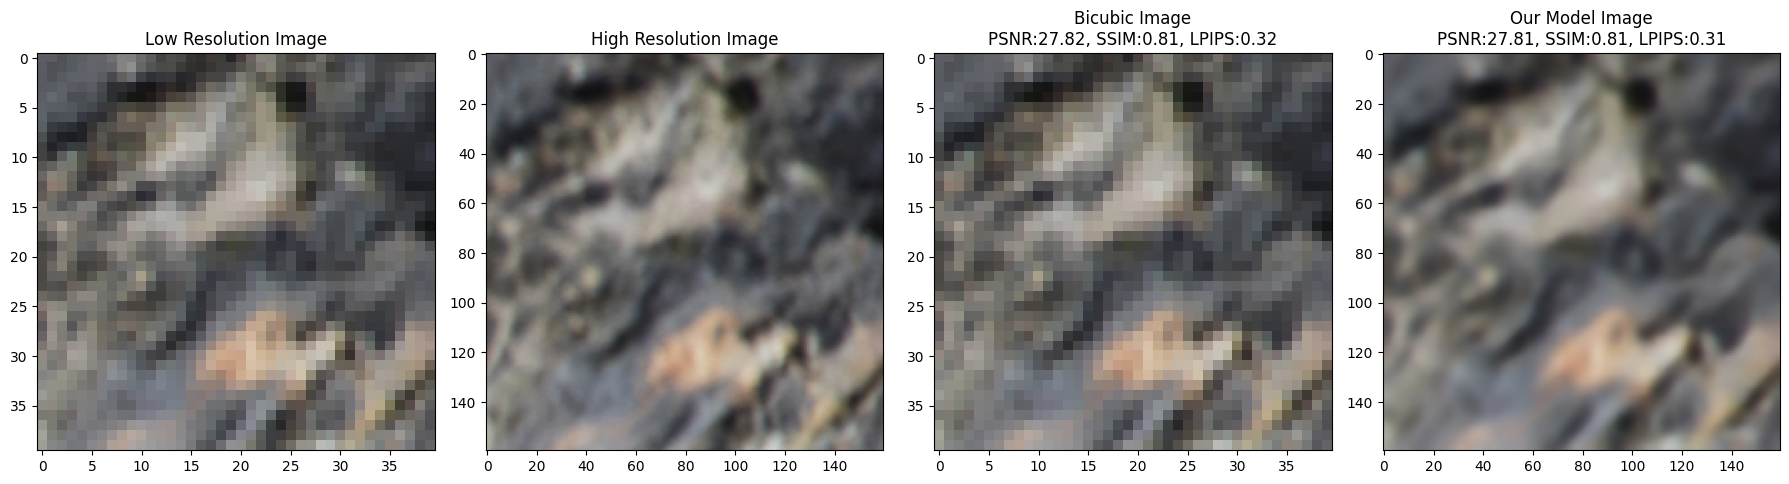

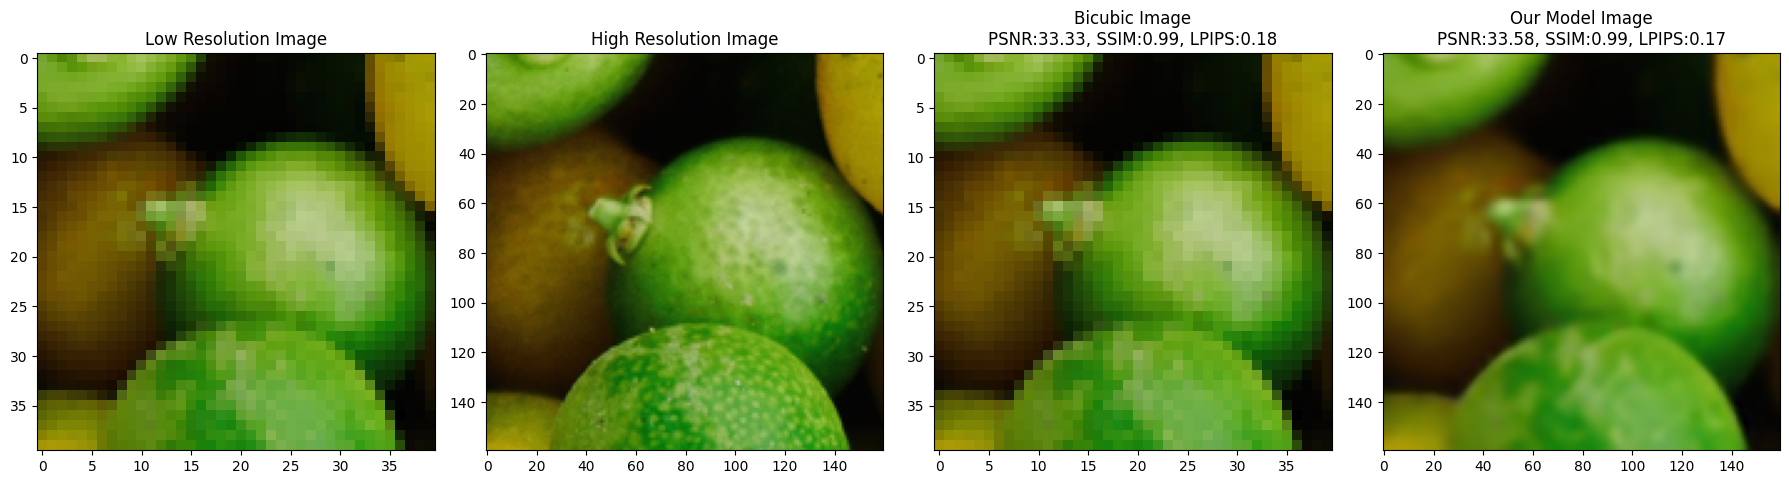

OutOfMemoryError: CUDA out of memory. Tried to allocate 766.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 543.06 MiB is free. Process 11473 has 14.21 GiB memory in use. Of the allocated memory 13.05 GiB is allocated by PyTorch, and 1.04 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
# extract a random patch from the image
for low_image_path, high_image_path in zip(low_resolution_validation_paths[:3], high_resolution_validation_paths[:3]):

  low_tensor,high_tensor,psnr_model,ssim_model,lpips_model,psnr_bicubic,ssims_bicubic,lpips_bicubic=model_evaluation(low_image_path,high_image_path)


  patch_size = 40
  _, H, W = low_tensor.shape
  x = torch.randint(0, W - patch_size, (1,)).item()
  y = torch.randint(0, H - patch_size, (1,)).item()
  low_patch = low_tensor[:, y:y+patch_size, x:x+patch_size]

  # Convert to YCbCr and extract Y channel
  low_patch_ycbcr = rgb2ycbcr(low_patch.permute(1, 2, 0).numpy())

  #Extract the y channel for model prediction
  low_patch_y = torch.from_numpy(low_patch_ycbcr[:,:,0]).unsqueeze(0)
  low_patch_cb = torch.from_numpy(low_patch_ycbcr[:,:,1]).unsqueeze(0)
  low_patch_cr = torch.from_numpy(low_patch_ycbcr[:,:,2]).unsqueeze(0)


  #get the corresponding high patch image for comparism
  high_x, high_y = x*4, y*4
  high_patch_size = patch_size * 4
  high_patch = high_tensor[:, high_y:high_y+high_patch_size, high_x:high_x+high_patch_size]

  # Convert high patch to YCbCr and extract Y channel
  high_patch_ycbcr = rgb2ycbcr(high_patch.permute(1, 2, 0).cpu().detach().numpy())

  high_patch_y = torch.from_numpy(high_patch_ycbcr[:,:,0]).unsqueeze(0)
  high_patch_cb = torch.from_numpy(high_patch_ycbcr[:,:,1]).unsqueeze(0)
  high_patch_cr = torch.from_numpy(high_patch_ycbcr[:,:,2]).unsqueeze(0)


  upsampling =nn.Upsample(scale_factor=4, mode='bicubic')


  inputs = upsampling(low_patch_y.unsqueeze(0)).squeeze(0).to(device)
  low_patch_upsampled_cb = upsampling(low_patch_cb.unsqueeze(0)).squeeze(0)
  low_patch_upsampled_cr = upsampling(low_patch_cr.unsqueeze(0)).squeeze(0)

  # Model prediction
  output = model(inputs)

  # Convert output back to RGB from YCb
  low_image_rgb = ycbcr2rgb(np.stack([output.squeeze().cpu().detach().numpy(), low_patch_upsampled_cb.squeeze().cpu().numpy(), low_patch_upsampled_cr.squeeze().cpu().numpy()], axis=-1))



  # concatenate all the channels and convert it back into an RGB
  low_patch_rgb = ycbcr2rgb(np.stack([low_patch_y.squeeze().numpy(),low_patch_cb.squeeze().numpy(),low_patch_cr.squeeze().numpy()], axis=-1))
  high_patch_rgb = ycbcr2rgb(np.stack([high_patch_y.squeeze().numpy(),high_patch_cb.squeeze().numpy(),high_patch_cr.squeeze().numpy()], axis=-1))
  out_patch_rgb = ycbcr2rgb(np.stack([output.squeeze().cpu().detach().numpy(),low_patch_upsampled_cb.squeeze().numpy(),low_patch_upsampled_cr.squeeze().numpy()], axis=-1))

  # plot the images for visualisation
  plt.figure(figsize=(18,16))


  plt.subplot(2,4,1)
  plt.imshow(low_patch_rgb, cmap='gray')
  plt.title("Low Resolution Image")

  plt.subplot(2,4,2)
  plt.imshow(high_patch_rgb, cmap='gray')
  plt.title("High Resolution Image")

  plt.subplot(2,4,3)
  plt.imshow(low_patch_rgb, cmap='gray')
  plt.title(f"Bicubic Image\nPSNR:{psnr_bicubic:.2f}, SSIM:{ssims_bicubic:.2f}, LPIPS:{lpips_bicubic:.2f}")

  plt.subplot(2,4,4)
  plt.imshow(out_patch_rgb, cmap='gray')
  plt.title(f"Our Model Image\nPSNR:{psnr_model:.2f}, SSIM:{ssim_model:.2f}, LPIPS:{lpips_model:.2f}")

  plt.tight_layout()
  plt.show()

  # deleting the tensor in order to free the memory.

  del low_tensor,high_tensor,low_patch,low_patch_ycbcr,low_patch_y,low_patch_cb,low_patch_cr


# **Evaluation of the model on the Set5 dataset**

For comparism purpose, we evaluated our model on the Set5 dataset below.


100%|██████████| 2.87M/2.87M [00:01<00:00, 2.45MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bdv212/set5-dataset/versions/1


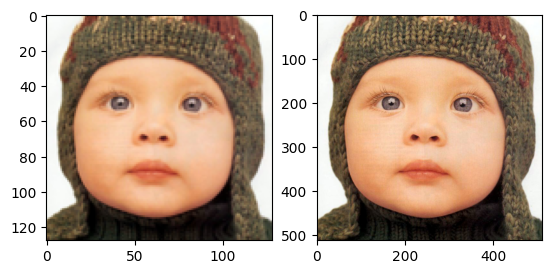

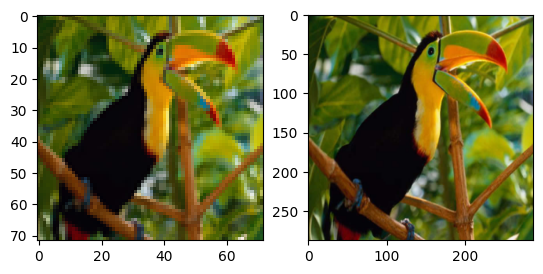

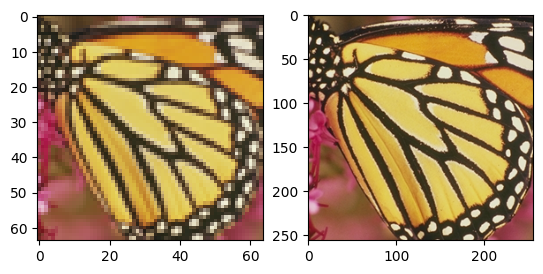

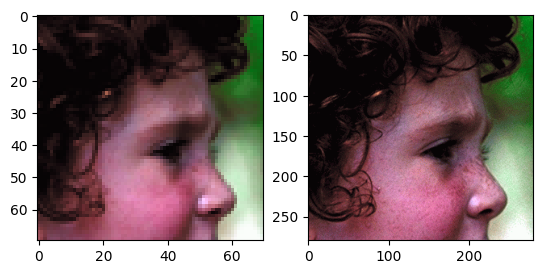

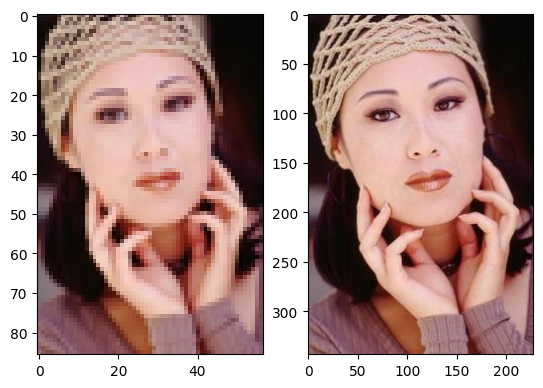

In [10]:
import kagglehub

# Download dataset, this was provided in the link https://www.kaggle.com/datasets/bdv212/set5-dataset?resource=download
path = kagglehub.dataset_download("bdv212/set5-dataset")

print("Path to dataset files:", path)


#process the path in order to extract the Set5 x4
image_path=os.listdir(path+'/'+os.listdir(path)[0])[1]
p=path+'/'+os.listdir(path)[0]+'/'+image_path
images=sorted(os.listdir(p))

# since both the high and low resolution are mixed in the list, we extracts the high and low resolution images
low_resolution_validation_paths=[]
high_resolution_validation_paths=[]

for i in range(len(images)):
  if i%2==0:
    high_resolution_validation_paths.append(p+'/'+images[i])
  else:
    low_resolution_validation_paths.append(p+'/'+images[i])

#plot them for visulisation
for low, high in zip(low_resolution_validation_paths,high_resolution_validation_paths):
  plt.subplot(1,2,1)
  plt.imshow(Image.open(low))
  plt.subplot(1,2,2)
  plt.imshow(Image.open(high))
  plt.show()

In [13]:
class SRCNN(nn.Module):
  '''
  The SRCNN model architecture
  '''
  def __init__(self,input_channel=3):
    super().__init__()

    self.patch_extractor=nn.Conv2d(input_channel,64,kernel_size=9, stride=1,padding=4)
    self.non_linear_function=nn.Conv2d(64,32,kernel_size=1,stride=1,padding=0)
    self.reconstruction=nn.Conv2d(32,input_channel,kernel_size=5,stride=1,padding=2)
    self.relu=nn.ReLU()



  def forward(self,x):

    x=self.relu(self.patch_extractor(x))
    x=self.relu(self.non_linear_function(x))
    x=self.reconstruction(x)


    return x


In [14]:
#Load the model weight for our model and SRCNN
model_srcnn=SRCNN().to(device)

our_model=VDSR().to(device)

our_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep learning Project/srfinal2.pth'))


model_srcnn.load_state_dict(torch.load('/content/drive/MyDrive/Deep learning Project/srfinal.pth'))

<ipython-input-14-ed0d6222b5ad>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  our_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep learning Project/srfinal2.

<All keys matched successfully>

In [15]:
def our_model_evaluation():

   # Define transform
  transform_to_tensor = transforms.ToTensor()
  psrn_vdsr=[]
  ssims_vdsr=[]
  lpips_vdsr=[]

  for i, (input_path, target_path) in enumerate(zip(low_resolution_validation_paths, high_resolution_validation_paths)):
    # Load images directly as PIL Images
    low_image = Image.open(input_path).convert('RGB')
    high_image =Image.open(target_path).convert('RGB')


    # Transform images to tensors
    low_tensor = transform_to_tensor(low_image).to(device)
    high_tensor = transform_to_tensor(high_image).to(device)

    # Convert high tensor to YCbCr and extract Y channel
    high_image_ycbcr = rgb2ycbcr(high_tensor.permute(1, 2, 0).cpu().numpy())
    low_image_ycbcr = rgb2ycbcr(low_tensor.permute(1, 2, 0).cpu().numpy())

    # Extract channels from YCbCr
    low_y = torch.from_numpy(low_image_ycbcr[:, :, 0]).unsqueeze(0).to(device)
    low_cb = torch.from_numpy(low_image_ycbcr[:, :, 1]).unsqueeze(0).to(device)
    low_cr = torch.from_numpy(low_image_ycbcr[:, :, 2]).unsqueeze(0).to(device)

    high_y = torch.from_numpy(high_image_ycbcr[:, :, 0]).unsqueeze(0).to(device)
    high_cb = torch.from_numpy(high_image_ycbcr[:, :, 1]).unsqueeze(0).to(device)
    high_cr = torch.from_numpy(high_image_ycbcr[:, :, 2]).unsqueeze(0).to(device)

    # Upsampling the y channel
    upsampling = nn.Upsample(scale_factor=4, mode='bicubic')
    inputs = upsampling(low_y.unsqueeze(0)).squeeze(0)  # Shape: [C, H', W']
    low_upsampled_cb = upsampling(low_cb.unsqueeze(0)).squeeze(0)
    low_upsampled_cr = upsampling(low_cr.unsqueeze(0)).squeeze(0)



    # Model prediction
    output_tensor = our_model(inputs)






    # Convert output back to RGB from YCbCr
    low_image_rgb = ycbcr2rgb(np.stack([output_tensor.squeeze().cpu().detach().numpy(), low_upsampled_cb.squeeze().cpu().numpy(), low_upsampled_cr.squeeze().cpu().numpy()], axis=-1))


    # Convert back into tensors for metrics calculation
    output_tensor = transform_to_tensor(low_image_rgb).to(device)


    # Convert back into tensors for metrics calculation
    output_tensor = transform_to_tensor(low_image_rgb).to(device)


    # Calculate metrics (LPIPS, PSNR, SSIM)
    lpips = lpips_loss(output_tensor, high_tensor.unsqueeze(0)).mean()  # Ensure shapes match for LPIPS calculation

    psnr_value = peak_signal_noise_ratio(output_tensor.cpu().squeeze().permute(1, 2, 0).detach().numpy(),
                                                  high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1.0)

    ssim_value = structural_similarity(output_tensor.cpu().squeeze().permute(1, 2, 0).detach().numpy(),
                                               high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                               win_size=3, data_range=1.0)

    psrn_vdsr.append(psnr_value)
    ssims_vdsr.append(ssim_value)
    lpips_vdsr.append(lpips.item())

  return psrn_vdsr,ssims_vdsr,lpips_vdsr

psrn_vdsr,ssims_vdsr,lpips_vdsr=our_model_evaluation()

print(f"Average PSNR for model VDSR images: {np.mean(psrn_vdsr)}")
print(f"Average SSIM for model VDSR images: {np.mean(ssims_vdsr)}")
print(f"Average LPIPS for model VDSR images: {np.mean(lpips_vdsr)}")



Average PSNR for model VDSR images: 27.43357753481785
Average SSIM for model VDSR images: 0.9235896068190069
Average LPIPS for model VDSR images: 0.24669260382652283


In [16]:
def srcnn_evaluation():

   # Define transform
  transform_to_tensor = transforms.ToTensor()
  psrn_srcnn=[]
  ssims_srcnn=[]
  lpips_srcnn=[]

  for i, (input_path, target_path) in enumerate(zip(low_resolution_validation_paths, high_resolution_validation_paths)):
    # Load images directly as PIL Images
    low_image = Image.open(input_path).convert('RGB')
    high_image =Image.open(target_path).convert('RGB')


    # Transform images to tensors
    low_tensor = transform_to_tensor(low_image).to(device)
    high_tensor = transform_to_tensor(high_image).to(device)


    upsampling = nn.Upsample(scale_factor=4, mode='bicubic')
    low_tensor=upsampling(low_tensor.unsqueeze(0)).squeeze(0)
    low_tensor=low_tensor.to(device)

    # Model prediction
    output_tensor = model_srcnn(low_tensor.unsqueeze(0))

    lpips = lpips_loss(output_tensor, high_tensor.unsqueeze(0)).mean()

    psnr_value = peak_signal_noise_ratio(output_tensor.cpu().squeeze().permute(1, 2, 0).detach().numpy(),
                                                  high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1.0)

    ssim_value = structural_similarity(output_tensor.cpu().squeeze().permute(1, 2, 0).detach().numpy(),
                                               high_tensor.cpu().squeeze().permute(1, 2, 0).numpy(),
                                               win_size=3, data_range=1.0)

    psrn_srcnn.append(psnr_value)
    ssims_srcnn.append(ssim_value)
    lpips_srcnn.append(lpips.item())

  return psrn_srcnn,ssims_srcnn,lpips_srcnn

psrn_srcnn,ssims_srcnn,lpips_srcnn=srcnn_evaluation()

print(f"Average PSNR for model SRCNN images: {np.mean(psrn_srcnn)}")
print(f"Average SSIM for model SRCNN images: {np.mean(ssims_srcnn)}")
print(f"Average LPIPS for model SRCNN images: {np.mean(lpips_srcnn)}")



Average PSNR for model SRCNN images: 27.8088736396674
Average SSIM for model SRCNN images: 0.9240739492626437
Average LPIPS for model SRCNN images: 0.20986586362123488
